In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth
import metpy

In [21]:
def map_adv(dato,clevels,titulo,variable,unidades):
    
    fig = plt.figure(figsize=(8, 10))
    lat = tas.lat
    lon = tas.lon
    #x, y, u, v, vector_crs = vientos(shape=(len(lon),len(lat)))

    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    plt.title(str(titulo))
    ax.coastlines('50m')
    ax.set_extent([-180,180, -90, 90], ccrs.PlateCarree())
    
    clevels = clevels
    im1=ax.contourf(lon, lat, dato,clevels,transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both') 
    
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, linestyle='-')
    #ax.quiver(lon,lat, u_h1 - u_h2, v_h1 - v_h2, transform=ccrs.PlateCarree(), regrid_shape=15)
    #Saco las coordenadas de la figura hasta ahora
    plt0_ax = plt.gca()
    left, bottom1, width, height = plt0_ax.get_position().bounds
    first_plot_left = plt0_ax.get_position().bounds[0]
    #Utilizo las coordenadas para definir la posición de la colorbar 1
    colorbar_axes = fig.add_axes([first_plot_left + .8, bottom1, 0.02, 1*height])
    cbar = plt.colorbar(im1, colorbar_axes, fraction=0.05, pad=0.04,aspect=18, orientation='vertical')
    #ticklabs = cbar.ax.get_yticklabels()
    #cbar.ax.set_yticklabels(ticklabs, fontsize=16)
    cbar.set_label(str(variable)+' ['+str(unidades)+']',fontsize=16)

    plt.show()

In [14]:
#Datos-----------------------------------------------------------------
path = '/home/tabu/Escritorio/Doctorado/ClimDinam/TP3/'
path2 = '/media/tabu/JULIAexterno/climatologia_dinamica/'

#Abro CanESM5 historico
tas = xr.open_dataset(path2+'CanESM5/tas_Amon_CanESM5_historical_ensmeani1p1f1_2.5.nc')
#Abro CanESM5 viento horizonte 1
tas_h1 = xr.open_dataset(path2+'CanESM5/tas_Amon_CanESM5_ssp585_ensmeani1p1f1_2020-2049_2.5.nc')
#Abro CanESM5 viento horizonte 2
tas_h2 = xr.open_dataset(path2+'CanESM5/tas_Amon_CanESM5_ssp585_ensmeani1p1f1_2070-2099_2.5.nc')

#Paso a celcius
tas_attrs = tas.tas.attrs 
t = tas.tas - 273.15
tas['tas'] = t
tas['tas'].attrs = tas_attrs
t_h1 = tas_h1.tas - 273.15
tas_h1['tas'] = t_h1
tas_h1['tas'].attrs = tas_attrs
t_h2 = tas_h2.tas - 273.15
tas_h2['tas'] = t_h2
tas_h2['tas'].attrs = tas_attrs

#Cambio longitudes
lon = np.arange(0,360, 362/144)
lon_attrs = tas.lon.attrs
tas['lon'] = lon
tas['lon'].attrs = lon_attrs
tas_h1['lon'] = lon
tas_h1['lon'].attrs = lon_attrs
tas_h2['lon'] = lon
tas_h2['lon'].attrs = lon_attrs
lat = tas.lat
lon = tas.lon

huss = xr.open_dataset(path2+'CanESM5/huss_Amon_CanESM5_historical_ensmeani1p1f1_2.5.nc')

huss_h1 = xr.open_dataset(path2+'CanESM5/huss_Amon_CanESM5_ssp585_r1i1p1f1_2020-2049_2.5.nc')

huss_h2 = xr.open_dataset(path2+'CanESM5/huss_Amon_CanESM5_ssp585_r1i1p1f1_2070-2099_2.5.nc')

#Cambio longitudes
huss['lon'] = lon
huss['lon'].attrs = lon_attrs
huss_h1['lon'] = lon
huss_h1['lon'].attrs = lon_attrs
huss_h2['lon'] = lon
huss_h2['lon'].attrs = lon_attrs

#Genero variable de unos
unos = huss.huss / huss.huss

#Genero datos para cada horizonte
variables_historical = tas.assign(huss = huss.huss)

variables_historical = variables_historical.assign(unos = unos)


In [61]:
ta_rean = xr.open_dataset(path2+'Reanalisis/tmp.mon.mean.nc')
rhum_rean = xr.open_dataset(path2+'Reanalisis/rhum.mon.mean.nc')
pl_rean = xr.open_dataset(path2+'Reanalisis/pl.mon.mean.nc')
ones_rean = rhum_rean.rhum/rhum_rean.rhum

lon = np.arange(0,360, 362/144)
lon_attrs = tas.lon.attrs
ta_rean['lon'] = lon
ta_rean['lon'].attrs = lon_attrs
rhum_rean['lon'] = lon
rhum_rean['lon'].attrs = lon_attrs
pl_rean['lon'] = lon
pl_rean['lon'].attrs = lon_attrs

## Calor sensible de aire seco
Ha = Cp*T con Cp = 1.005 Ha en [kJ/hg]

In [15]:
Ha = 1.005*ta_rean.air
Ha_mod = 1.005*variables_historical.tas

In [16]:
Ha_clim = Ha.mean(dim='time')
Ha_mod_clim = Ha_mod.mean(dim='time')

## Sacar la humedad específica a partir de la humedad relativa
q = 0.622 / (pa/ea - 0.378)

donde ea es la presión de vapor y pa es la presión en superficie

La humedad relativa es la fracción de presión de vapor de agua sobre presión de vapor de agua saturada. Se multiplica por 100 para tener un porcentaje.

RH = 100* ea/esa

entonces ea lo podemos sacar de

ea = RH*esa/100

esat = 10*((0.7859+0.03477T)/(1+0.00412*T) + 2)

In [81]:
e_sat = 10**((0.7859+0.03477*ta_rean.air)/(1+0.00412*ta_rean.air)+2)

In [82]:
rhum = rhum_rean.rhum/100
Hv = (2502- 0.538*ta_rean.air)*(0.622/(((pl_rean.pres)/(rhum*e_sat))-0.378))

In [83]:
Hv_mod = variables_historical.huss*(2502 - 0.538*variables_historical.tas)

In [84]:
Hv_clim = Hv.mean(dim='time')
Hv_mod_clim = Hv_mod.mean(dim='time')

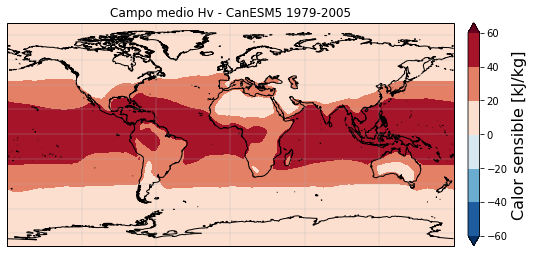

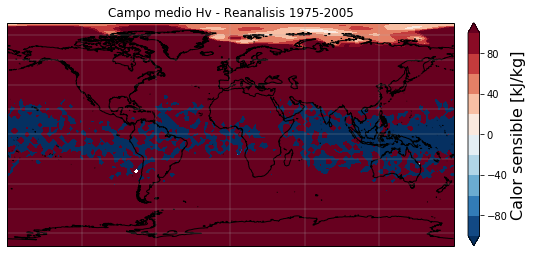

In [86]:
titulo = 'Campo medio Hv - CanESM5 1979-2005'
clevels = np.arange(-60,80,20)
variable = 'Calor sensible'
unidades = 'kJ/kg'
map_adv(Hv_mod_clim,clevels,titulo,variable,unidades)

titulo = 'Campo medio Hv - Reanalisis 1975-2005'
clevels = np.arange(-100,120,20)
variable = 'Calor sensible'
unidades = 'kJ/kg'
map_adv(Hv_clim,clevels,titulo,variable,unidades)

titulo = 'Campo medio Hv - Bias'
clevels = np.arange(-60,80,20)
variable = 'Calor sensible'
unidades = 'kJ/kg'
#map_adv(Hv_mod_clim - Hv_clim,clevels,titulo,variable,unidades)